In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import os
from tqdm.notebook import tqdm
from pydub import AudioSegment
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
patient_data=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['patient_id','disease'])

In [4]:
patient_data.head()

patient_id  disease
0         101     URTI
1         102  Healthy
2         103   Asthma
3         104     COPD
4         105     URTI

In [5]:
patient_data.shape

(126, 2)

In [6]:
patient_data['disease'].value_counts()

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

# Annoatation text file columns

In [7]:
one_annotation_file = pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')

In [8]:
one_annotation_file
# column 1 - Beginning of respiratory cycle(s)
# column 2 - End of respiratory cycle(s)
# column 3 - Presence/absence of crackles (presence=1, absence=0)
# column 4 - Presence/absence of wheezes (presence=1, absence=0)

1.862   5.718  0  1
0   5.718   9.725  1  1
1   9.725  13.614  0  1
2  13.614  17.671  0  1
3  17.671  19.541  0  0

Reading all annotation files

In [9]:
path='/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = path) if '.txt' in s]

In [10]:
filenames[:10]

['168_1b1_Al_sc_Meditron',
 '172_1b4_Ar_mc_AKGC417L',
 '130_3p2_Pr_mc_AKGC417L',
 '177_2b4_Pl_mc_AKGC417L',
 '130_2p5_Pl_mc_AKGC417L',
 '109_1b1_Pr_sc_Litt3200',
 '170_1b2_Pr_mc_AKGC417L',
 '147_2b3_Lr_mc_AKGC417L',
 '102_1b1_Ar_sc_Meditron',
 '158_1p3_Pr_mc_AKGC417L']

Convert filename into dataframe and join with the content which is inside each file

In [11]:
count = 0
for s in filenames:
    print(s.split('_'))
    count+=1
    if count == 1:
        break
        
# In below list
# 1st column is the patient id
# 2nd column is recording index
# 3rd column is chest location
# 4th column is Acquisition mode 
# 5th column is Recording equipment 

['168', '1b1', 'Al', 'sc', 'Meditron']


Converting all files into dataframe with relevant headers

In [12]:
patient_id = []
recording_idx = []
chest_location = []
acquisition_mode = []
recording_equipment = []

for file in filenames:
    file = file.split('_')
    patient_id.append(file[0])
    recording_idx.append(file[1])
    chest_location.append(file[2])
    acquisition_mode.append(file[3])
    recording_equipment.append(file[4])


data = {
    'patient_id' : patient_id,
    'recording_idx' : recording_idx,
    'chest_location' : chest_location,
    'acquisition_mode' : acquisition_mode,
    'recording_equipment' : recording_equipment
}
    
annotation_df = pd.DataFrame(data)
annotation_df.head()

patient_id recording_idx chest_location acquisition_mode recording_equipment
0        168           1b1             Al               sc            Meditron
1        172           1b4             Ar               mc            AKGC417L
2        130           3p2             Pr               mc            AKGC417L
3        177           2b4             Pl               mc            AKGC417L
4        130           2p5             Pl               mc            AKGC417L

In [13]:
annotation_df.shape

(920, 5)

In [14]:
def get_file_name(file):
    return file.split('_')

In [15]:
file_data = []
for file in tqdm(filenames):
    data = pd.read_csv(path + file + '.txt', sep='\t', names = ['start','end','crackles','wheezes'])
    individual_file = get_file_name(file)
    data['patient_id'] = individual_file[0]
    data['recording_idx'] = individual_file[1]
    data['chest_location'] = individual_file[2]
    data['acquisition_mode'] = individual_file[3]
    data['filename'] = file
    file_data.append(data)
    

  0%|          | 0/920 [00:00<?, ?it/s]

In [16]:
files_df = pd.concat(file_data)
files_df.reset_index()
files_df.head()

start     end  crackles  wheezes patient_id recording_idx chest_location  \
0   0.036   2.436         0        0        168           1b1             Al   
1   2.436   5.250         0        0        168           1b1             Al   
2   5.250   8.422         0        0        168           1b1             Al   
3   8.422  11.222         0        0        168           1b1             Al   
4  11.222  13.807         0        0        168           1b1             Al   

  acquisition_mode                filename  
0               sc  168_1b1_Al_sc_Meditron  
1               sc  168_1b1_Al_sc_Meditron  
2               sc  168_1b1_Al_sc_Meditron  
3               sc  168_1b1_Al_sc_Meditron  
4               sc  168_1b1_Al_sc_Meditron

In [17]:
files_df.shape

(6898, 9)

Now we can join patient_data with files_df on column patient_id

In [18]:
patient_data.patient_id=patient_data.patient_id.astype('int32')
files_df.patient_id=files_df.patient_id.astype('int32')

In [19]:
final_df = pd.merge(files_df,patient_data,on='patient_id')


In [20]:
final_df.tail()

start     end  crackles  wheezes  patient_id recording_idx  \
6893  11.062  13.202         0        0         127           1b1   
6894  13.202  15.384         1        0         127           1b1   
6895  15.384  17.167         0        0         127           1b1   
6896  17.167  19.421         1        0         127           1b1   
6897  19.421  19.934         0        0         127           1b1   

     chest_location acquisition_mode                filename  disease  
6893             Ar               sc  127_1b1_Ar_sc_Meditron  Healthy  
6894             Ar               sc  127_1b1_Ar_sc_Meditron  Healthy  
6895             Ar               sc  127_1b1_Ar_sc_Meditron  Healthy  
6896             Ar               sc  127_1b1_Ar_sc_Meditron  Healthy  
6897             Ar               sc  127_1b1_Ar_sc_Meditron  Healthy

In [21]:
final_df['crackles'].value_counts()

crackles
0    4528
1    2370
Name: count, dtype: int64

In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6898 entries, 0 to 6897
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start             6898 non-null   float64
 1   end               6898 non-null   float64
 2   crackles          6898 non-null   int64  
 3   wheezes           6898 non-null   int64  
 4   patient_id        6898 non-null   int32  
 5   recording_idx     6898 non-null   object 
 6   chest_location    6898 non-null   object 
 7   acquisition_mode  6898 non-null   object 
 8   filename          6898 non-null   object 
 9   disease           6898 non-null   object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 512.1+ KB


In [23]:
# os.makedirs('csv_data')
# data.to_csv('csv_data/data.csv',index=False)

# Processing Wave Files/ Audio files

Playing audio file

In [24]:
audio_file = '104_1b1_Ar_sc_Litt3200.wav'
audio_path='/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file
print(audio_path)

/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav


In [25]:
# pip install sounddevice

In [26]:
import IPython.display as ipd
ipd.display(ipd.Audio('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav', rate=7000))

In [27]:
ipd.display(ipd.Audio('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b5_Ll_mc_AKGC417L.wav', rate=7000))

In [28]:
filename1 = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav'
filename2 = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b5_Ll_mc_AKGC417L.wav'

In [29]:
"""
loads and decodes the audio as a time series y, represented as a one-dimensional NumPy floating point array. 
The variable sr contains the sampling rate of y, that is, the number of samples per second of audio. 
By default, all audio is mixed to mono and resampled to 22050 Hz at load time. 

The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples.

beat_times will be an array of timestamps (in seconds) corresponding to detected beat events.
"""
y1, sr1 = librosa.load(filename1)
print(y1,sr1)
tempo1, beat_frames1 = librosa.beat.beat_track(y=y1, sr=sr1)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo1))

beat_times1 = librosa.frames_to_time(beat_frames1, sr=sr1)
print(f"Beat times for file 1: {beat_times1}")

[ 0.00076246  0.00089785  0.00091902 ... -0.00491839 -0.00254905
  0.        ] 22050
Estimated tempo: 0.00 beats per minute
Beat times for file 1: []


In [30]:
y2, sr2 = librosa.load(filename2)
print(y2,sr2)

tempo2, beat_frames2 = librosa.beat.beat_track(y=y2, sr=sr2)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo2))

beat_times2 = librosa.frames_to_time(beat_frames2, sr=sr2)
print(f"Beat times for file 2: {beat_times2}")

[ 0.          0.          0.         ... -0.00108671  0.00123263
 -0.00136357] 22050
Estimated tempo: 136.00 beats per minute
Beat times for file 2: [ 0.11609977  0.55727891  1.021678    1.50929705  1.9969161   2.48453515
  2.99537415  3.41333333  3.83129252  4.27247166  4.71365079  5.15482993
  5.59600907  6.03718821  6.47836735  6.91954649  7.36072562  7.80190476
  8.2430839   8.68426304  9.14866213  9.58984127 10.05424036 10.4954195
 10.91337868 11.33133787 11.74929705 12.21369615 12.67809524 13.16571429
 13.58367347 14.00163265 14.41959184 14.83755102 15.27873016 15.7199093
 16.13786848 16.55582766 16.9970068 ]


# Plotting audio file

In [31]:
# File 1
print(type(y1), type(sr1))
print(y1.shape, sr1)

<class 'numpy.ndarray'> <class 'int'>
(564128,) 22050


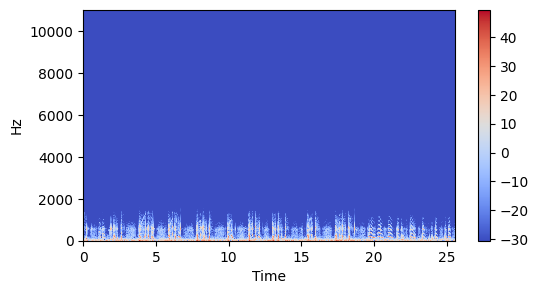

In [32]:
Y1 = librosa.stft(y1)
Ydb1 = librosa.amplitude_to_db(abs(Y1))
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb1, sr=sr1, x_axis='time', y_axis='hz')
plt.colorbar()

<class 'numpy.ndarray'> <class 'int'>
(441000,) 22050


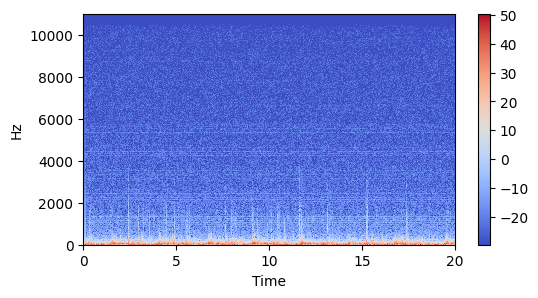

In [33]:
"""
.stft() converts data into short term Fourier transform. 
STFT converts signals such that we can know the amplitude of the given frequency at a given time. 
Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal. 
.specshow is used to display a spectrogram.
"""
# File 2
print(type(y2), type(sr2))
print(y2.shape, sr2)
Y2 = librosa.stft(y2)
Ydb2 = librosa.amplitude_to_db(abs(Y2))
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb2, sr=sr2, x_axis='time', y_axis='hz')
plt.colorbar()

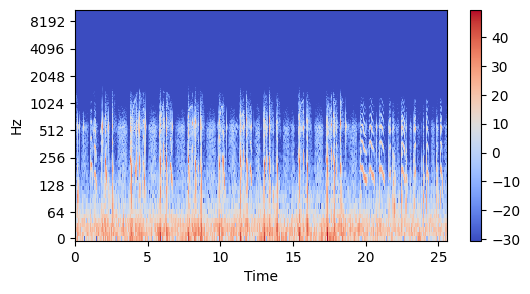

In [34]:
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb1, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar()

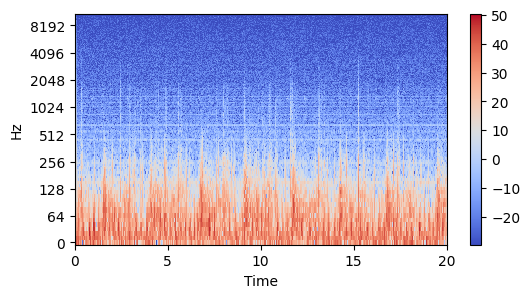

In [35]:
plt.figure(figsize=(6, 3))
librosa.display.specshow(Ydb2, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar()

(20, 1102)


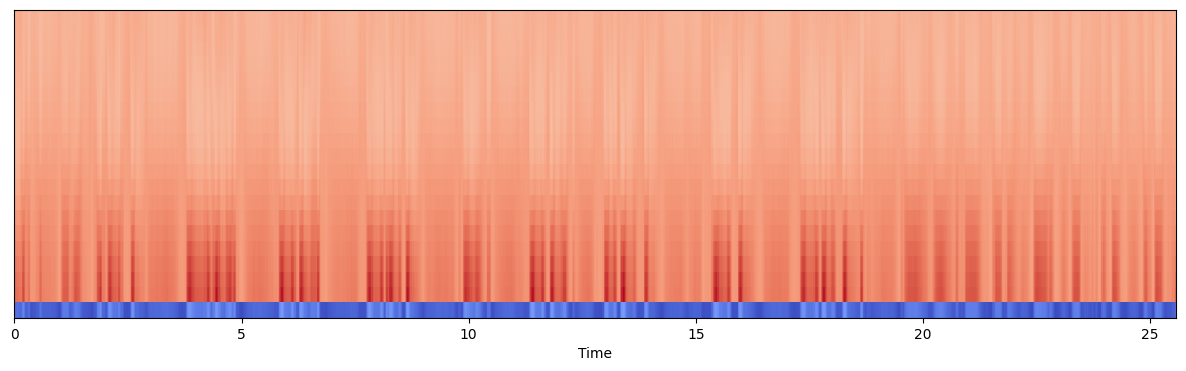

In [36]:
fs=10
mfccs = librosa.feature.mfcc(y=y1, sr=fs)
print(mfccs.shape)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 4))
librosa.display.specshow(mfccs, sr=sr1, x_axis='time')

# Processing Audio Files

In [37]:
def GetPureAudio(raw, start, end, sr=22050):
    '''
    It is used to extract a portion of audio data from a numpy array based on specified start and end times. 
    
    raw=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw[start_ind: end_ind]

We also want our input images of same size to be fed into CNN. To achieve this, I will choose a fixed duration (e.g., the maximum duration that fits your use case) and extract audio segments of that fixed duration from each audio file.
I am using scatterplot to find the max duration

<Axes: >

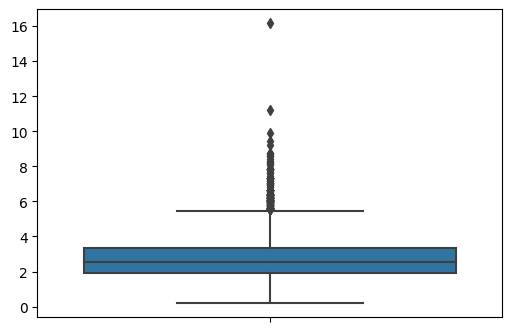

In [38]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=(final_df.end - final_df.start))

From these plots we can conclude that best length is ~6

Also if difference is less than 6 we must Zero Pad it to get it to required length

Zero Padding means silent


In [39]:
# Creating directory for storing process audio files
os.makedirs('processed_audio_files')

A single audio can have more than 1 repsiratory cycle. So we have to create file for each respiratory cycle

In [46]:
i = 0
c = 0
for index, row in tqdm(final_df.iterrows()):
    max_length = 6
    start_time = row['start']
    end_time = row['end']
    filename = row['filename']
    
    # if segment duration exceeds the maximum then truncate it
    if end_time - start_time > max_length:
        end = start_time + max_length
    
    audio_file_location = path + filename + '.wav'
    
    # Checking if this row is part of the same patient's audio recording
    if index > 0:
        if final_df.iloc[index-1]['filename'] == filename:
            i += 1
        else:
            i = 0
    filename = filename + '_' + str(i) + '.wav'
    save_path = 'processed_audio_files/' + filename
    c += 1
    
    # Loading original audio file and getting pure audio
    audio, samplerate = librosa.load(audio_file_location)
    pure_sample = GetPureAudio(audio ,start_time ,end_time,samplerate)
    
    # Calculating required length
    required_length = max(6 * samplerate, len(pure_sample))
    padded_data = librosa.util.pad_center(pure_sample, size=required_length)
    
# split    
    # Save the processed audio segment to the specified path
    sf.write(file=save_path, data=padded_data, samplerate=samplerate)
    
print('Total Files Processed: ',c)

0it [00:00, ?it/s]

Total Files Processed:  6898


# Handling Imbalance Class

In [1]:
sns.countplot(data=patient_data, x='disease')
plt.xticks(rotation = 45)

NameError: name 'sns' is not defined

We will try to extract Id of each processed audio file and then merge them with their respective class label so we can split files in to train and validation folder in stratified manner

In [43]:
def extract_patient_id(filename):
    return filename.split('_')[0]

In [44]:
path = '/kaggle/working/processed_audio_files/'
ssss = [s.split('_')[0] for s in os.listdir(path = path)]
ssss[:1]

['198']

Creating dataframe for patient_id and its associated filename

In [45]:
length=len(os.listdir(path))
index=range(length)
i=0
patient_df=pd.DataFrame(index=index,columns=['patient_id','filename'])
for f in os.listdir(path):
    patient_df.iloc[i]['patient_id']=extract_patient_id(f)
    patient_df.iloc[i]['filename']=f
    i+=1

In [46]:
patient_df.head()

patient_id                      filename
0        198  198_6p1_Ar_mc_AKGC417L_4.wav
1        220  220_1b2_Al_mc_LittC2SE_5.wav
2        205  205_4b2_Pl_mc_AKGC417L_1.wav
3        154  154_1b3_Ll_mc_AKGC417L_9.wav
4        203  203_1p4_Pl_mc_AKGC417L_2.wav

In [47]:
patient_df.patient_id=patient_df.patient_id.astype('int64') # both pid's must be of same dtype for them to merge


In [48]:
df = pd.merge(patient_df, patient_data, on='patient_id')

In [49]:
df.head()

patient_id                      filename disease
0         198  198_6p1_Ar_mc_AKGC417L_4.wav    COPD
1         198  198_6p1_Tc_mc_AKGC417L_4.wav    COPD
2         198  198_1b5_Pr_mc_AKGC417L_4.wav    COPD
3         198  198_1b5_Ll_mc_AKGC417L_2.wav    COPD
4         198  198_1b5_Al_mc_AKGC417L_2.wav    COPD

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'COPD'),
  Text(1, 0, 'URTI'),
  Text(2, 0, 'Bronchiectasis'),
  Text(3, 0, 'Bronchiolitis'),
  Text(4, 0, 'Pneumonia'),
  Text(5, 0, 'Healthy'),
  Text(6, 0, 'LRTI'),
  Text(7, 0, 'Asthma')])

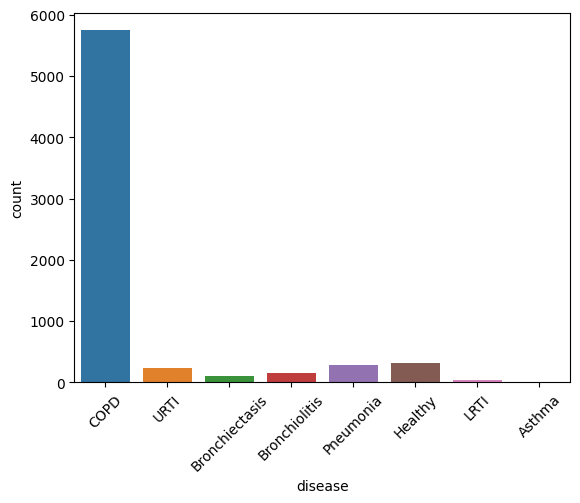

In [50]:
sns.countplot(data=df, x='disease')
plt.xticks(rotation = 45)

# Splitting into train and test

In [51]:
X_train,X_test,y_train,y_test=train_test_split(df,df.disease,stratify=df.disease,random_state=42,test_size=0.25)

In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5173, 3)
(1725, 3)
(5173,)
(1725,)


In [53]:
X_train.disease.value_counts()/X_train.shape[0]

disease
COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: count, dtype: float64

In [54]:
X_test.disease.value_counts()/X_test.shape[0]

disease
COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: count, dtype: float64

In [55]:
X_train.to_csv('train.csv')

In [56]:
X_test.to_csv('test.csv')

# Feature Extracting and Modelling

In [57]:
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')

In [58]:
train.head()

Unnamed: 0  patient_id                      filename  disease
0        1413         213  213_2p2_Ar_mc_AKGC417L_3.wav     COPD
1        6079         159  159_1b1_Ll_sc_Meditron_7.wav  Healthy
2         473         203  203_1p2_Pl_mc_AKGC417L_0.wav     COPD
3        6544         202  202_1b1_Ar_sc_Meditron_7.wav  Healthy
4        1212         222  222_1b1_Pr_sc_Meditron_6.wav     COPD

In [59]:
test.head()

Unnamed: 0  patient_id                      filename disease
0        2993         107  107_2b3_Ar_mc_AKGC417L_7.wav    COPD
1        2748         193  193_1b2_Pr_mc_AKGC417L_3.wav    COPD
2         825         185  185_1b1_Ar_sc_Litt3200_6.wav    COPD
3         556         203  203_1p3_Pl_mc_AKGC417L_7.wav    COPD
4        4410         178  178_1b3_Tc_mc_AKGC417L_1.wav    COPD

In [60]:
# Extracting target from train and test
y_train=train.disease
y_test=test.disease

In [61]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Feature Extraction

In [62]:
def get_features_from_audio(path):
    soundArr,sample_rate= librosa.load(path)
    mfcc=librosa.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=librosa.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=librosa.feature.melspectrogram(y=soundArr,sr=sample_rate)
    tone = librosa.feature.tonnetz(y=soundArr,sr=sample_rate)
    specCen = librosa.feature.spectral_centroid(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec,tone, specCen

### Fetching features for test data


MFCC (Mel-frequency cepstral coefficients):

Relevance: MFCCs are widely used in audio analysis because they approximate the human auditory system's response to sound. They capture the spectral characteristics of audio, making them suitable for tasks like speech and sound recognition.
Effectiveness: MFCCs summarize the spectral content of an audio signal by representing it as a set of coefficients. These coefficients are effective at characterizing different sound patterns and are often used as input features for machine learning models in audio classification tasks.
Chroma Short-Time Fourier Transform (STFT):

Relevance: Chroma features are particularly useful for music and sound analysis, as they focus on pitch and tonal information. They represent the distribution of energy in different musical pitch classes.
Effectiveness: Chroma features can help distinguish between different musical instruments, chords, and melodies in audio recordings. They are valuable for tasks related to music and tonal sounds.
Mel Spectrogram:

Relevance: The Mel spectrogram is another representation of the spectral content of audio signals. It provides a visual representation of how audio energy is distributed across different frequency bands, with a focus on human auditory perception.
Effectiveness: Mel spectrograms are useful for capturing the timbral characteristics of audio, such as the texture and tone. They can help differentiate between different types of sounds based on their spectral patterns.

In [63]:
root = '/kaggle/working/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(test.iterrows()):
    path=root + row['filename']
    a,b,c,d,e=get_features_from_audio(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [64]:
shapes = [np.shape(sub_list) for sub_list in mfcc]

unique_shapes = set(shapes)

print(unique_shapes)

{(20, 304), (20, 267), (20, 276), (20, 273), (20, 300), (20, 370), (20, 309), (20, 315), (20, 260), (20, 263), (20, 269), (20, 278), (20, 287), (20, 259), (20, 268), (20, 274), (20, 338), (20, 277), (20, 356)}


In [65]:
shapes1 = [np.shape(sub_list) for sub_list in cstft]

unique_shapes1 = set(shapes1)

print(unique_shapes1)

{(12, 370), (12, 309), (12, 315), (12, 260), (12, 263), (12, 269), (12, 278), (12, 287), (12, 259), (12, 268), (12, 274), (12, 338), (12, 277), (12, 356), (12, 304), (12, 267), (12, 273), (12, 276), (12, 300)}


In [66]:
shapes2 = [np.shape(sub_list) for sub_list in mSpec]

unique_shapes2 = set(shapes2)

print(unique_shapes2)

{(128, 267), (128, 273), (128, 276), (128, 300), (128, 370), (128, 309), (128, 315), (128, 260), (128, 263), (128, 269), (128, 278), (128, 287), (128, 259), (128, 268), (128, 274), (128, 338), (128, 277), (128, 356), (128, 304)}


In [67]:
# Determine the minimum shape among all subarrays for mfcc
min_shape = min(sub_array.shape for sub_list in mfcc for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mfcc_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mfcc
]

# Determine the minimum shape among all subarrays for cstft
min_shape = min(sub_array.shape for sub_list in cstft for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
cstft_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in cstft
]

# Determine the minimum shape among all subarrays for mSpec
min_shape = min(sub_array.shape for sub_list in mSpec for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mSpec_padded = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mSpec
]

In [68]:
# Converting the padded list of lists of NumPy arrays into a NumPy array
mfcc_test = np.array(mfcc_padded)
cstft_test = np.array(cstft_padded)
mSpec_test = np.array(mSpec_padded)

print(f"mfcc: {mfcc_test.shape}")
print(f"cstft: {cstft_test.shape}")
print(f"mSpec: {mSpec_test.shape}")

mfcc: (1725, 20, 259)
cstft: (1725, 12, 259)
mSpec: (1725, 128, 259)


### Similarly fetching features for training data

In [69]:
root = '/kaggle/working/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(train.iterrows()):
    path=root + row['filename']
    a,b,c,d,e=get_features_from_audio(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

0it [00:00, ?it/s]

In [70]:
shapes = [np.shape(sub_list) for sub_list in mfcc]
unique_shapes = set(shapes)
print(unique_shapes)

{(20, 304), (20, 371), (20, 377), (20, 328), (20, 267), (20, 264), (20, 270), (20, 276), (20, 273), (20, 697), (20, 288), (20, 407), (20, 285), (20, 303), (20, 483), (20, 428), (20, 309), (20, 315), (20, 321), (20, 260), (20, 263), (20, 269), (20, 272), (20, 397), (20, 336), (20, 281), (20, 278), (20, 284), (20, 348), (20, 287), (20, 351), (20, 357), (20, 302), (20, 299), (20, 314), (20, 311), (20, 317), (20, 375), (20, 262), (20, 259), (20, 329), (20, 268), (20, 274), (20, 338), (20, 277), (20, 286), (20, 295), (20, 353), (20, 362), (20, 301)}


In [71]:
shapes = [np.shape(sub_list) for sub_list in cstft]
unique_shapes = set(shapes)
print(unique_shapes)

{(12, 303), (12, 483), (12, 428), (12, 309), (12, 315), (12, 260), (12, 263), (12, 321), (12, 272), (12, 397), (12, 269), (12, 336), (12, 281), (12, 278), (12, 284), (12, 348), (12, 287), (12, 351), (12, 357), (12, 299), (12, 302), (12, 311), (12, 317), (12, 375), (12, 314), (12, 262), (12, 259), (12, 329), (12, 268), (12, 274), (12, 338), (12, 277), (12, 286), (12, 353), (12, 362), (12, 295), (12, 301), (12, 304), (12, 371), (12, 377), (12, 267), (12, 264), (12, 270), (12, 328), (12, 273), (12, 697), (12, 276), (12, 407), (12, 285), (12, 288)}


In [72]:
shapes = [np.shape(sub_list) for sub_list in mSpec]
unique_shapes = set(shapes)
print(unique_shapes)

{(128, 377), (128, 264), (128, 328), (128, 267), (128, 273), (128, 697), (128, 276), (128, 270), (128, 285), (128, 288), (128, 407), (128, 303), (128, 309), (128, 428), (128, 483), (128, 315), (128, 321), (128, 260), (128, 263), (128, 269), (128, 272), (128, 278), (128, 397), (128, 336), (128, 281), (128, 287), (128, 284), (128, 351), (128, 348), (128, 299), (128, 357), (128, 302), (128, 311), (128, 375), (128, 314), (128, 259), (128, 317), (128, 262), (128, 329), (128, 268), (128, 274), (128, 338), (128, 277), (128, 286), (128, 295), (128, 353), (128, 304), (128, 362), (128, 301), (128, 371)}


In [73]:
# Determine the minimum shape among all subarrays for mfcc
min_shape = min(sub_array.shape for sub_list in mfcc for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mfcc_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mfcc
]

# Determine the minimum shape among all subarrays for cstft
min_shape = min(sub_array.shape for sub_list in cstft for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
cstft_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in cstft
]

# Determine the minimum shape among all subarrays for mSpec
min_shape = min(sub_array.shape for sub_list in mSpec for sub_array in sub_list)
# Padding each subarray to the minimum shape with zeros
mSpec_padded_train = [
    [sub_array[:min_shape[0]] for sub_array in sub_list]
    for sub_list in mSpec
]

In [74]:
# Converting the padded list of lists of NumPy arrays into a NumPy array
mfcc_train = np.array(mfcc_padded_train)
cstft_train = np.array(cstft_padded_train)
mSpec_train = np.array(mSpec_padded_train)

print(f"mfcc: {mfcc_train.shape}")
print(f"cstft: {cstft_train.shape}")
print(f"mSpec: {mSpec_train.shape}")

mfcc: (5173, 20, 259)
cstft: (5173, 12, 259)
mSpec: (5173, 128, 259)


# Modelling

Setting parameters which will help to stop the model when it starts overfitting

In [75]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=0.00001,
)
]

`We will create 3 different CNN's and then combine them to Dense Network

In [78]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [79]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 20, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 22, 64)        18

In [80]:
cstft_input=keras.layers.Input(shape=(12,259,1),name="cstftInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(cstft_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
cstft_output=keras.layers.GlobalMaxPooling2D()(x)

cstft_model=keras.Model(cstft_input, cstft_output, name="cstftModel")

In [81]:
cstft_model.summary()

Model: "cstftModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cstftInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_8 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 22, 64)         1

In [92]:
mspec_input=keras.layers.Input(shape=(128,259,1),name="mspecInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mspec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mspec_output=keras.layers.GlobalMaxPooling2D()(x)

mspec_model=keras.Model(mspec_input, mspec_output, name="mspecModel")

In [93]:
mspec_model.summary()

Model: "mspecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mspecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 87, 32)       832       
                                                                 
 batch_normalization_20 (Bat  (None, 128, 87, 32)      128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 128, 87, 32)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 22, 64)        1

In [94]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_cstft=keras.layers.Input(shape=(12,259,1),name="cstft")
cstft=cstft_model(input_cstft)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mspec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,cstft,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_cstft,input_mSpec], output, name="Net")

In [95]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 cstft (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

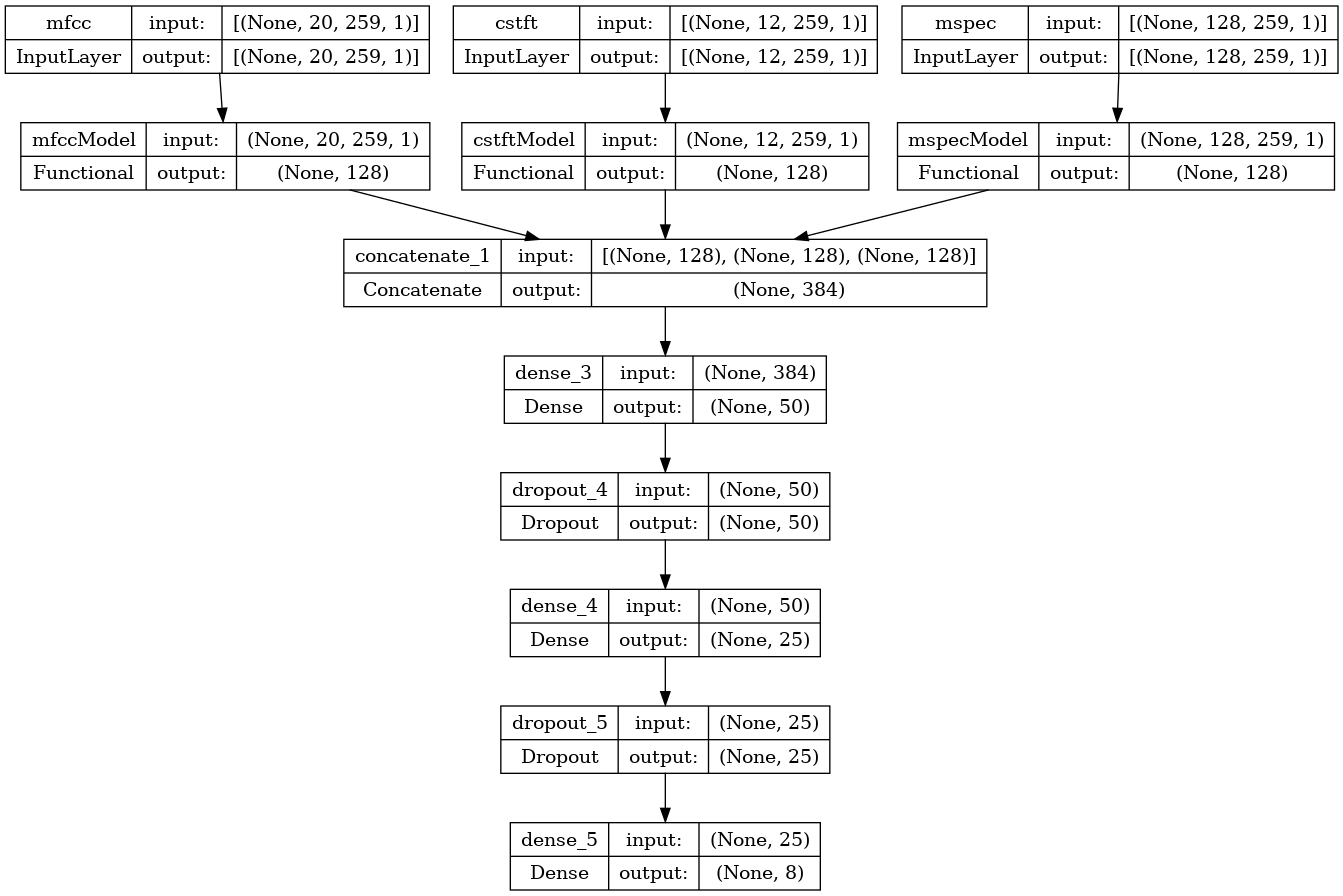

In [96]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [97]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [98]:
history=net.fit(
    {"mfcc":mfcc_train,"cstft":cstft_train,"mspec":mSpec_train},
    y_train,
    validation_data=({"mfcc":mfcc_test,"cstft":cstft_test,"mspec":mSpec_test},y_test),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
162/162 [==============================] - 63s 339ms/step - loss: 0.7821 - accuracy: 0.7858 - val_loss: 0.6823 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 54s 333ms/step - loss: 0.5383 - accuracy: 0.8312 - val_loss: 0.5703 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 54s 333ms/step - loss: 0.4419 - accuracy: 0.8455 - val_loss: 0.5459 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 54s 333ms/step - loss: 0.4193 - accuracy: 0.8508 - val_loss: 0.4227 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 54s 331ms/step - loss: 0.3656 - accuracy: 0.8622 - val_loss: 0.4764 - val_accuracy: 0.8243 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 54s 332ms/step - loss: 0.3609 - accuracy: 0.8637 - val_loss: 0.3682 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 7/100
162/162 [=========================

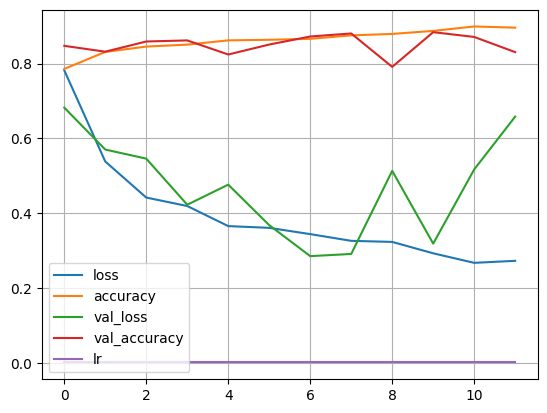

In [101]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()